# 8.2 Exemple pràctic: MNIST

Exemple de classificació de MNIST amb xarxes neuronals



In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
# carreguem les mostres d'aprenentatge de 64 en 64
batch_size_train = 64
# les mostres de test les carreguem de 1000 en 1000
batch_size_test = 1000


data_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

# Preparem el conjunt d'aprenentatge i de test
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True, transform=data_transform), 
    batch_size=batch_size_train, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True, transform=data_transform), 
    batch_size=batch_size_test, 
    shuffle=True)

In [11]:
# Mostrem un batch de test, tindrà 1000 mostres
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# els batches de test tindran 1000 imatges d'un canal (nivells de gris) i 28x28 píxels
print('batch size {}, canals {}, ample {}, alt {}'.format(example_data.shape[0], example_data.shape[1], example_data.shape[2], example_data.shape[3]))
# les etiquetes, seran de batch size x 1 (l'objectiu de classificació)
print('Labels {}'.format(example_targets.shape[0]))

batch size 1000, canals 1, ample 28, alt 28
Labels 1000


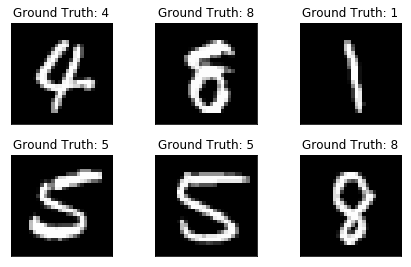

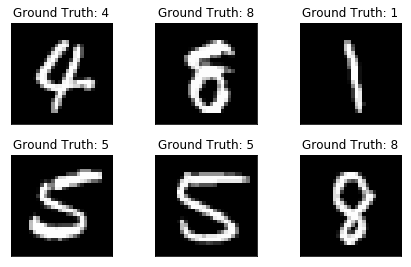

In [12]:
# mostrem unes quantes mostres de les dades amb la seva etiqueta
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [13]:
# Arquitectura
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        num_classes = 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_classes)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        

In [14]:
# Entrenament

learning_rate = 0.01
momentum = 0.5
log_interval = 10

# per a que els experiments siguin repetibles, fixem el random seed de pytorch
random_seed = 34343
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# creem una instància de la nostra arquitectura
network = Net()

print(network)

total_params = sum(p.numel() for p in network.parameters())
print('total parameters {}'.format(total_params))

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

criterion = nn.CrossEntropyLoss()


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
total parameters 21840


In [15]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())


In [16]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += criterion(output, target)
            # test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, 
                correct, 
                len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

In [17]:
n_epochs = 3
train_losses = []
test_losses = []

# Mostrem el rendiment inicial (amb pesos inicialitzats aleatòriament)
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Test set: Avg. loss: 0.0002, Accuracy: 97/10000 (1%)
Test set: Avg. loss: 0.0002, Accuracy: 194/10000 (2%)
Test set: Avg. loss: 0.0002, Accuracy: 305/10000 (3%)
Test set: Avg. loss: 0.0002, Accuracy: 387/10000 (4%)
Test set: Avg. loss: 0.0002, Accuracy: 484/10000 (5%)
Test set: Avg. loss: 0.0002, Accuracy: 592/10000 (6%)
Test set: Avg. loss: 0.0002, Accuracy: 696/10000 (7%)
Test set: Avg. loss: 0.0002, Accuracy: 781/10000 (8%)
Test set: Avg. loss: 0.0002, Accuracy: 874/10000 (9%)
Test set: Avg. loss: 0.0002, Accuracy: 980/10000 (10%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335399
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298673
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.296643
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279348
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.252630
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.262945
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.206760
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.217785
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.101651
Train Epoch: 1 [5760/60000 (10%)

Test set: Avg. loss: 0.0000, Accuracy: 971/10000 (10%)
Test set: Avg. loss: 0.0000, Accuracy: 1940/10000 (19%)
Test set: Avg. loss: 0.0000, Accuracy: 2912/10000 (29%)
Test set: Avg. loss: 0.0000, Accuracy: 3889/10000 (39%)
Test set: Avg. loss: 0.0000, Accuracy: 4866/10000 (49%)
Test set: Avg. loss: 0.0000, Accuracy: 5839/10000 (58%)
Test set: Avg. loss: 0.0000, Accuracy: 6806/10000 (68%)
Test set: Avg. loss: 0.0000, Accuracy: 7776/10000 (78%)
Test set: Avg. loss: 0.0000, Accuracy: 8746/10000 (87%)
Test set: Avg. loss: 0.0000, Accuracy: 9719/10000 (97%)


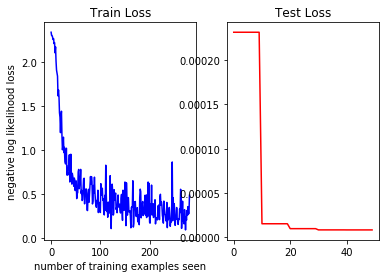

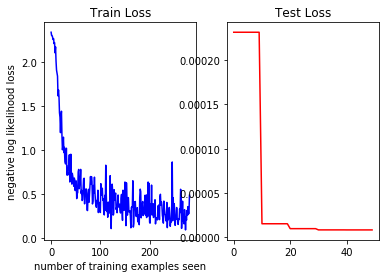

In [18]:
# mostrem els resultats de classificació un cop entrenat
test()

fig = plt.figure()
plt.subplot(1,2,1)
plt.plot(train_losses, color='blue')

plt.title('Train Loss')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.subplot(1,2,2)
plt.title('Test Loss')
plt.plot(test_losses, color='red')

fig

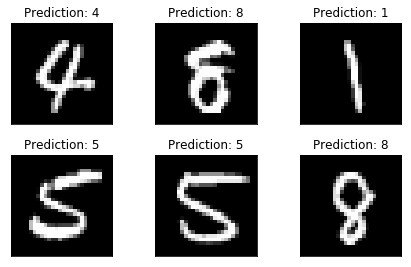

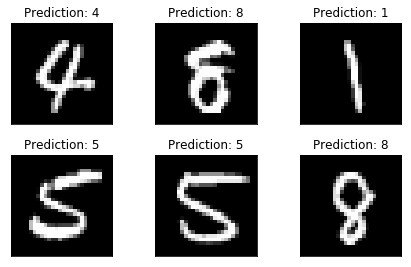

In [19]:
# classifiquem unes quantes mostres

with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig